In [1]:
import pandas as pd
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import copy
from scipy.stats import shapiro, pearsonr, kruskal
import tabulate
from tabulate import tabulate
import numpy as np
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Final Project: Predicting an NFL Player's Draft Position Based on Combine Performance

The NFL combine is a way for aspiring NFL players to showcase their skills, it is a way to get noticed by NFL scouts and teams. Players attend the combine with the hope to improve their draft stock, get drafted higher, and in return get more money for it. It is a nerve filled experience with the understanding that one mistake can hurt their chance of getting drafted at all. The goal of this project is to determine how much effect the combine has on a draft prospect. Are there certain drills that have a higher weight towards their draft stock, and how does performance of these drills vary from position to position? Does a bad combine performance mean that player will get drafted later?

We are going to be creating classification models in order to predict which round a player gets drafted in. 

Here is some background information that might be of use. The NFL draft is made of up 7 rounds. Each round has 32 picks, one for each of the 32 teams. So when a player is drafted by team, they get drafted at a certain overall / pick. This is just a running count of all the draft picks that have happened so far, starting at pick number one. 

So the player that is picked at number one is seen to be the best player available in the entire draft for the team that is picking them. 

But as mentioned previously, in this project we are just going to be classifying based on rounds. That is just because classifying based on the overall pick they are holds way too many options and it would be unlikely that the model could predict any correctly. So by limiting it to just the round they were drafted we can hope to see some accurate results. 

# Research Question

How does combine performance affect the draft stock of an NFL athlete?

# Hypothesis

The better the NFL draftees combine performance, the higher they will get drafted.  

# Datasets

We used two datasets for this project 

1. [Combine Data on Kaggle](https://www.kaggle.com/datasets/mitchellweg1/nfl-combine-results-dataset-2000-2022)
2. [Draft Order Data on Kaggle](https://www.kaggle.com/datasets/jacklichtenstein/espn-nfl-draft-prospect-data?resource=download)

The first dataset outlines the players and their combine statistics. This includes a player’s time for their 40 yard dash, their weight, height, bench press, etc. We want to analyze which of these drills impact the player’s draft stock the most. For instance, how does a slower 40 yard dash hurt a wide receiver's draft position? Or does a drill like bench press affect how a quarterback is drafted? Using a combination of these variables we hope that we can predict where a player is going to be drafted with reasonable accuracy. 

In order to do that we need another dataset that highlights the player’s draft position. The second Kaggle dataset has data from each player drafted from 1967 to 2021, and the position that player was drafted. We can combine the draft position data with the combine data to train a model to make accurate predictions on the draft position of the player. 


# Data Preprocessing

Data in these datasets is not going to be perfect. There are going to be a lot of missing values since not every player participates in ALL of the combine drills. There is more than likely going to be class imbalances as well, player's that get drafted in the first round may not even bother showing up to the combine, and there may not be many players from the first round in this dataset

But first, we need to merge these datasets together in order to be able to determine the draft position based on the player's combine stats.


In [2]:
csv_files = glob.glob('./combine-data/*.csv')
draft_df = pd.read_csv('./draft-data/nfl_draft_prospects.csv')
comb_df = pd.DataFrame()

for file in csv_files:
    df = pd.read_csv(file)
    comb_df = pd.concat([comb_df, df])

select_df = draft_df[['draft_year', 'player_name', 'school', 'pick', 'overall', 'round']]
select_df.head()

,draft_year,player_name,school,pick,overall,round
0,1967,Bubba Smith,Michigan State,1.0,1.0,1.0
1,1967,Clinton Jones,Michigan State,2.0,2.0,1.0
2,1967,Steve Spurrier,Florida,3.0,3.0,1.0
3,1967,Bob Griese,Purdue,4.0,4.0,1.0
4,1967,George Webster,Michigan State,5.0,5.0,1.0


In [3]:
merged_df = pd.merge(comb_df, select_df, left_on=['Player', 'School'], right_on=['player_name', 'school'], how='inner')
merged_df = merged_df.drop(['player_name', 'school'], axis=1)

In [4]:
comb_df.head(10)

,Player,Pos,School,Ht,Wt,40yd,Vertical,Bench,Broad Jump,3Cone,Shuttle
0,John Abraham,OLB,South Carolina,6-4,252.0,4.55,NaN,NaN,NaN,NaN,NaN
1,Shaun Alexander,RB,Alabama,6-0,218.0,4.58,NaN,NaN,NaN,NaN,NaN
2,Darnell Alford,OT,Boston Col.,6-4,334.0,5.56,25.0,23.0,94.0,8.48,4.98
3,Kyle Allamon,TE,Texas Tech,6-2,253.0,4.97,29.0,NaN,104.0,7.29,4.49
4,Rashard Anderson,CB,Jackson State,6-2,206.0,4.55,34.0,NaN,123.0,7.18,4.15
5,Jake Arians,K,Ala-Birmingham,5-10,202.0,NaN,NaN,NaN,NaN,NaN,NaN
6,LaVar Arrington,OLB,Penn State,6-3,250.0,4.53,NaN,NaN,NaN,NaN,NaN
7,Corey Atkins,OLB,South Carolina,6-0,237.0,4.72,31.0,21.0,112.0,7.96,4.39
8,Kyle Atteberry,K,Baylor,6-0,167.0,NaN,NaN,NaN,NaN,NaN,NaN
9,Reggie Austin,CB,Wake Forest,5-9,175.0,4.44,35.0,17.0,119.0,7.03,4.14


In [5]:
merged_df.head(10)

,Player,Pos,School,Ht,Wt,40yd,Vertical,Bench,Broad Jump,3Cone,Shuttle,draft_year,pick,overall,round
0,John Abraham,OLB,South Carolina,6-4,252.0,4.55,NaN,NaN,NaN,NaN,NaN,2000,13.0,13.0,1.0
1,Shaun Alexander,RB,Alabama,6-0,218.0,4.58,NaN,NaN,NaN,NaN,NaN,2000,19.0,19.0,1.0
2,Rashard Anderson,CB,Jackson State,6-2,206.0,4.55,34.0,NaN,123.0,7.18,4.15,2000,23.0,23.0,1.0
3,LaVar Arrington,OLB,Penn State,6-3,250.0,4.53,NaN,NaN,NaN,NaN,NaN,2000,2.0,2.0,1.0
4,Reggie Austin,CB,Wake Forest,5-9,175.0,4.44,35.0,17.0,119.0,7.03,4.14,2000,31.0,125.0,4.0
5,Mark Baniewicz,OT,Syracuse,6-6,312.0,5.34,28.0,20.0,96.0,7.72,4.73,2000,41.0,247.0,7.0
6,Rashidi Barnes,S,Colorado,6-0,208.0,4.62,35.0,10.0,114.0,6.92,4.32,2000,19.0,225.0,7.0
7,David Barrett,CB,Arkansas,5-10,199.0,4.44,37.5,16.0,116.0,6.81,4.04,2000,8.0,102.0,4.0
8,William Bartee,CB,Oklahoma,6-1,192.0,4.43,38.5,NaN,124.0,6.70,3.99,2000,23.0,54.0,2.0
9,Robert Bean,CB,Mississippi State,5-11,178.0,4.50,34.5,NaN,122.0,6.87,4.20,2000,4.0,133.0,5.0


## Handling Missing Values

Missing values are something that is a little tricky with this dataset. There are a lot of missing values, but it is not as easy as filling them in or dropping the ones that have missing data. There is supposed to be missing values, that is because some positions don't do certain drills. For instance quarterbacks do not participate in the bench press drill. So this is going to have to be very position specific. 

There are also variables such as the height that need to be turned into an actual numeric representation and not the string representation that it is now.

In [6]:
def convert_height(height):
    '''
    This method converts the parameter height into two decimal places. 
    This is neccesary because the given value is of type string and a numerical 
    representation for it is needed.
    :param height: 
    :return: 
    '''
    if height:
        feet = int(str(height)[0:1])
        inches_str = str(height)[2:]
        if inches_str:  
            inches = int(inches_str)
            return str(feet + round(inches / 12, 2))
    return None

merged_df = merged_df.dropna(subset=['Ht'])
merged_df['Ht'] = merged_df.Ht.apply(lambda x: convert_height(x))

In [7]:
# All the positions possible
positions = ['CB', 'OT', 'S', 'OG', 'ILB', 'DE', 'RB', 'FB', 'TE', 'OLB', 'DT',
       'C', 'WR', 'QB', 'LS', 'EDGE', 'LB', 'OL', 'DL', 'DB']
filtered_positions = ['CB', 'OT', 'S', 'OG', 'ILB', 'DE', 'RB', 'FB', 'TE', 'OLB', 'DT',
       'C', 'WR', 'EDGE', 'LB', 'OL', 'DL', 'DB']
# All of the drills being performed
drills = ['40yd', 'Vertical', 'Bench', 'Broad Jump', '3Cone', 'Shuttle']

drill_count_per_position = {'Pos' : [], '40yd' : [], 'Vertical' : [], 'Bench' : [], 'Broad Jump' : [], '3Cone' : [], 'Shuttle' : []}

To get an idea of what positions do what drills we are count how drills are done for each position. 

In [8]:
for position in positions:
    drill_count_per_position['Pos'].append(position)
    for drill in drills:
        count = merged_df[merged_df['Pos'] == position][drill].dropna().size
        drill_count_per_position[drill].append(count)

In [9]:
drill_count_per_position_df = pd.DataFrame(drill_count_per_position)
drill_count_per_position_df.head(20)

,Pos,40yd,Vertical,Bench,Broad Jump,3Cone,Shuttle
0,CB,509,420,411,421,323,331
1,OT,343,290,289,286,268,273
2,S,351,304,306,303,221,222
3,OG,230,188,195,184,174,180
4,ILB,180,148,149,146,114,119
5,DE,347,277,271,274,242,248
6,RB,391,332,314,325,234,233
7,FB,74,65,61,65,61,61
8,TE,255,213,213,207,183,183
9,OLB,333,273,261,278,235,240


This gives a pretty good idea of what positions partake in what drills. For instance, QB's do not seem to partake in the bench press. But this also shows how some positions do not have many players. For instance LS (Long Snapper) has next to no data associated with it. But for the drills we are going to administer on, we need to make sure that the players have participated in ALL of the drills. Not just some. So lets see how many players per each position have participated in all of the drills...

In [10]:
count_per_pos = {}
for position in positions:
    temp = merged_df[merged_df['Pos'] == position].dropna()
    count_per_pos[position] = temp.size

print(count_per_pos)

{'CB': 3300, 'OT': 2910, 'S': 2295, 'OG': 1935, 'ILB': 1095, 'DE': 2670, 'RB': 2310, 'FB': 630, 'TE': 2010, 'OLB': 2580, 'DT': 2280, 'C': 975, 'WR': 2610, 'QB': 30, 'LS': 15, 'EDGE': 180, 'LB': 300, 'OL': 555, 'DL': 405, 'DB': 240}


There seems to be a sufficent amount of data for each position. However, there are positions that do not make sense to analyze based on combine performance alone. One of those positions is Quarterback. The combine drills in this dataset does not account for how well they throw, which of course is the most important skill for a QB. Another is a Long Snapper, they just do not have enough data to use in this dataset. Besides those two positions every other position should be okay to do.  

In [11]:
# Removing those positions now
merged_df = merged_df[(merged_df['Pos'] != 'QB') & (merged_df['Pos'] != 'LS')]
merged_df = merged_df.dropna()

Now lets grab only the necessary data. We are not going to need to know which pick they were, their name, the school they went to. We are not trying to predict any of those variables, nor are we trying to predict on any of those variables.

In [12]:
cols_to_exclude = ['Player', 'draft_year', 'overall', 'School', 'pick']
final_combine_data = merged_df.drop(cols_to_exclude, axis=1)
final_combine_data.head()

,Pos,Ht,Wt,40yd,Vertical,Bench,Broad Jump,3Cone,Shuttle,round
4,CB,5.75,175.0,4.44,35.0,17.0,119.0,7.03,4.14,4.0
5,OT,6.5,312.0,5.34,28.0,20.0,96.0,7.72,4.73,7.0
6,S,6.0,208.0,4.62,35.0,10.0,114.0,6.92,4.32,7.0
7,CB,5.83,199.0,4.44,37.5,16.0,116.0,6.81,4.04,4.0
11,S,6.08,207.0,4.62,39.5,15.0,119.0,6.48,4.29,2.0


## Handling Class Imbalances

The NFL draft is composed of seven rounds. Each round has 32 picks for each of the 32 teams. 

We do not want there to be more players in certain rounds or that might bias the results. Let's see if there are severe class imbalances going on, if so we need to handle them accordingly.

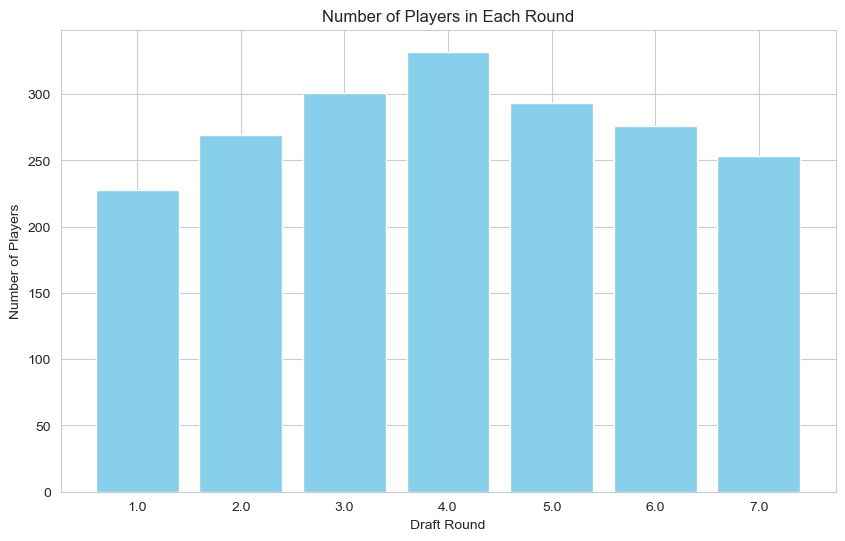

In [13]:
round_counts = final_combine_data['round'].value_counts().sort_index()

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(round_counts.index.astype(str), round_counts.values, color='skyblue')
plt.xlabel('Draft Round')
plt.ylabel('Number of Players')
plt.title('Number of Players in Each Round')
plt.show()

Some rounds clearly do have more players than other rounds. But there is another imbalance we have to worry about, that being positional imbalances. Some rounds may have more players in a certain position than other rounds do. For instance, if there are 20 WR's in round 1 and only 4 in round 7, the model might bias towards round 1. 

In [14]:
def get_position_count_per_round(pos):
    '''
    This method will return a list corresponding to the number of players per position for that round. 
    '''
    result = []
    for round in range(1,8):
        for position in [pos]:
            result.append(final_combine_data[(final_combine_data['round'] == round) & (final_combine_data['Pos'] == position)].shape[0])
    return result

Now we can rebalance all of the rounds to have the same number of players per position. We want to only include positions that have at least ten players in each round just to make sure there is adequate data. And then make sure that there is the same number of players in each round per position. At the end we should have seven rounds, all of equal size.

In [15]:
THRESHOLD = 10 # minimum number of players per round
balanced_final_combine_data = pd.DataFrame()

for round in range(1,8):
    for position in final_combine_data['Pos'].unique():
        min_player_count = np.min(get_position_count_per_round(position))
        if min_player_count >= THRESHOLD:
            df = final_combine_data[(final_combine_data['round'] == round) & (final_combine_data['Pos'] == position)]
            random_samples = df.sample(n=min_player_count)
            balanced_final_combine_data = pd.concat([balanced_final_combine_data, random_samples], ignore_index=True)

final_combine_data = balanced_final_combine_data

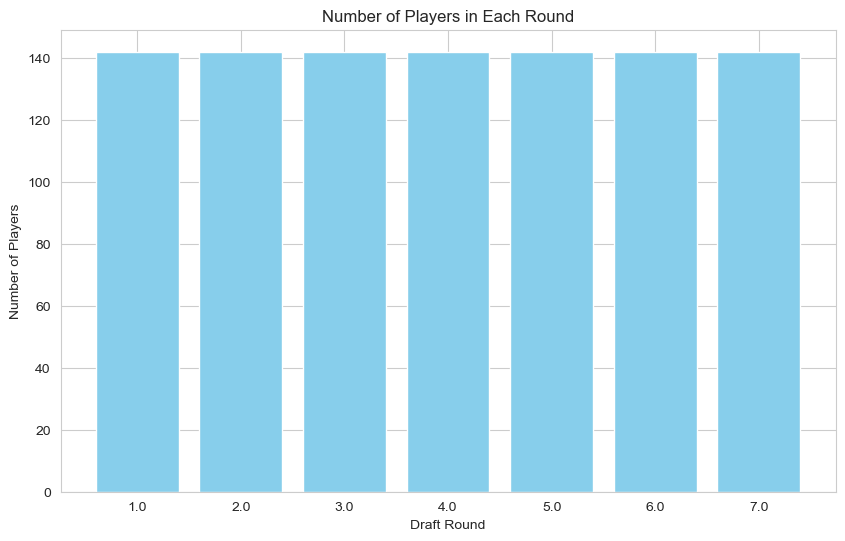

In [16]:
round_counts = final_combine_data['round'].value_counts().sort_index()

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(round_counts.index.astype(str), round_counts.values, color='skyblue')
plt.xlabel('Draft Round')
plt.ylabel('Number of Players')
plt.title('Number of Players in Each Round')
plt.show()

In [17]:
pears_list = []
for pos in filtered_positions:
    pos_df = merged_df[merged_df["Pos"] == pos]
    for drill in drills:
        pears, p = pearsonr(x=pos_df[drill], y=pos_df['overall'])
        pears_list.append([str(pos), drill, pears, p])
      
pears_header = ["Position", "Drill", "Pearson Coefficient", "P value"]
# print(tabulate(pears_list, headers=pears_header, tablefmt="grid"))
pears_df = pd.DataFrame(pears_list)
pears_df.head(108)

,0,1,2,3
0,CB,40yd,0.321129,0.000001
1,CB,Vertical,-0.148725,0.027408
2,CB,Bench,-0.100245,0.138302
3,CB,Broad Jump,-0.233329,0.000484
4,CB,3Cone,0.239351,0.000341
...,...,...,...,...
103,DB,Vertical,0.030043,0.912055
104,DB,Bench,0.101532,0.708291
105,DB,Broad Jump,0.002045,0.994002
106,DB,3Cone,0.266228,0.318925


And now we need to make the position variable categorical, so by using one hot encoding we can do that

In [18]:
final_combine_data = pd.get_dummies(final_combine_data, columns=['Pos'])
final_combine_data.head()

,Ht,Wt,40yd,Vertical,Bench,Broad Jump,3Cone,Shuttle,round,Pos_CB,Pos_DE,Pos_DT,Pos_OG,Pos_OLB,Pos_OT,Pos_RB,Pos_S,Pos_TE,Pos_WR
0,6.0,186.0,4.31,38.0,19.0,122.0,7.06,4.39,1.0,1,0,0,0,0,0,0,0,0,0
1,6.08,198.0,4.52,36.0,23.0,125.0,6.95,3.96,1.0,1,0,0,0,0,0,0,0,0,0
2,5.92,193.0,4.52,35.0,18.0,125.0,6.94,4.34,1.0,1,0,0,0,0,0,0,0,0,0
3,6.0,193.0,4.44,34.0,17.0,118.0,6.67,4.15,1.0,1,0,0,0,0,0,0,0,0,0
4,6.0,190.0,4.49,38.5,12.0,128.0,6.90,4.19,1.0,1,0,0,0,0,0,0,0,0,0


# Visualizing the Data

Different positions excel at different drills in the combine. Example, wide receivers are going to run a faster 40yd dash than offensive lineman. Let's visualize these differences.

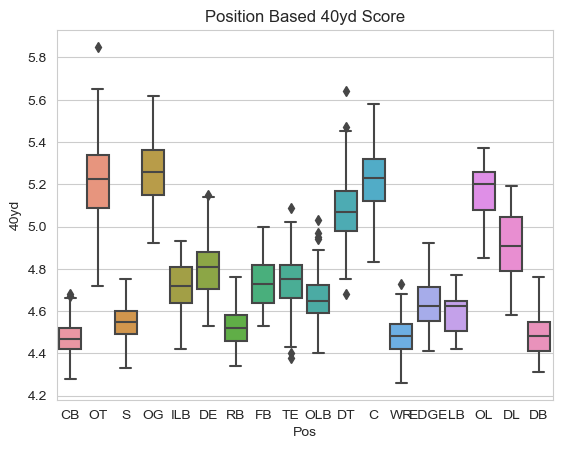

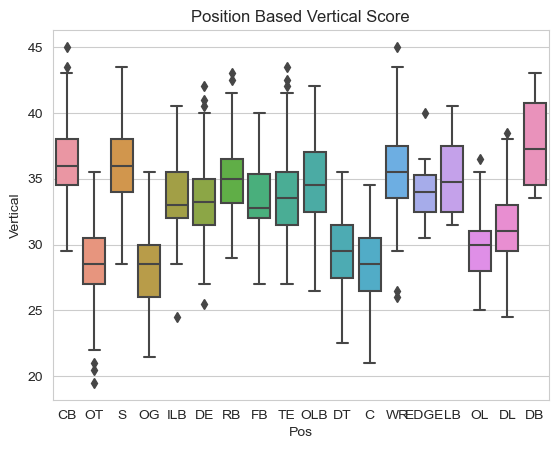

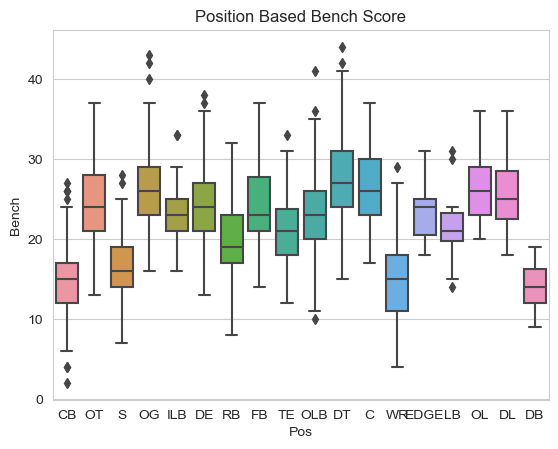

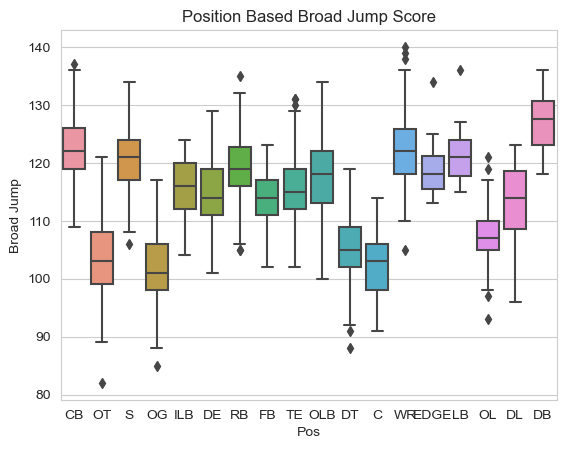

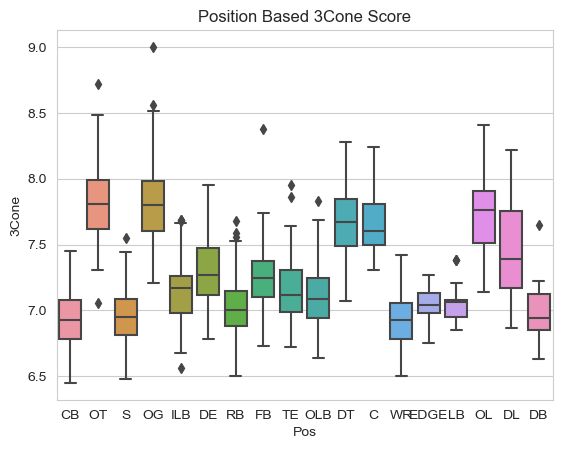

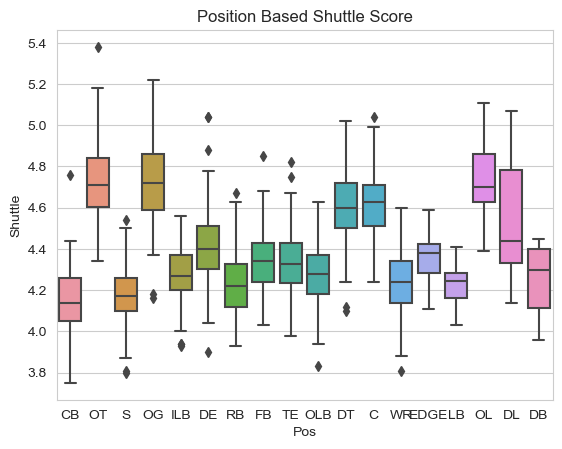

<Figure size 640x480 with 0 Axes>

In [19]:
forty_dash = merged_df.dropna(subset=['40yd'])
# sns.scatterplot(data=merged_df, x='overall', y='40yd')
# print(forty_dash['Pos'].unique())
for drill in drills:
    drill_df = merged_df.dropna(subset=[drill])
    sns.boxplot(data=drill_df, x='Pos', y=drill)
    plt.title("Position Based " + drill + " Score")
    plt.show()
    plt.clf()

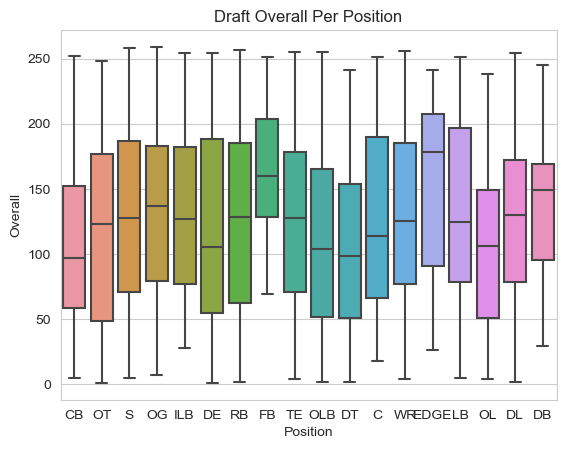

In [20]:
sns.boxplot(data=merged_df, x='Pos', y='overall')
plt.title("Draft Overall Per Position")
plt.xlabel('Position')
plt.ylabel('Overall')
plt.show()

### See if Data is normally distributed

In [21]:
alpha = 0.05
for drill in drills:
    drill_df = merged_df.dropna(subset=[drill])
    for pos in filtered_positions:
        pos_df = drill_df[drill_df['Pos'] == pos]
        statistic, p_value = shapiro(pos_df[drill])
        if p_value < alpha:
            print("Position: " + pos + " at Drill: " + drill + " is NOT normally distributed")

Position: OL at Drill: 40yd is NOT normally distributed
Position: RB at Drill: Vertical is NOT normally distributed
Position: LB at Drill: Vertical is NOT normally distributed
Position: DB at Drill: Vertical is NOT normally distributed
Position: CB at Drill: Bench is NOT normally distributed
Position: ILB at Drill: Bench is NOT normally distributed
Position: DE at Drill: Bench is NOT normally distributed
Position: FB at Drill: Bench is NOT normally distributed
Position: TE at Drill: Broad Jump is NOT normally distributed
Position: LB at Drill: Broad Jump is NOT normally distributed
Position: OG at Drill: 3Cone is NOT normally distributed
Position: RB at Drill: 3Cone is NOT normally distributed
Position: FB at Drill: 3Cone is NOT normally distributed
Position: TE at Drill: 3Cone is NOT normally distributed
Position: C at Drill: 3Cone is NOT normally distributed
Position: LB at Drill: 3Cone is NOT normally distributed
Position: DB at Drill: 3Cone is NOT normally distributed
Position: CB 

### Many Positions have non uniform distributions of drills
It is wise to Use Kruskal-Wallis test knowing this. Anova testing requires for data to be uniform

In [22]:
kruskal_tests = []
kruskal_head = ['Drill', 'Stat', 'P Value']
for drill in drills:
    drill_df = merged_df.dropna(subset=[drill])
    samples_by_group = []
    for value in set(drill_df[drill]):
        mask = drill_df[drill] == value
        samples_by_group.append(drill_df['Pos'][mask]) 
    stat, p = kruskal(*samples_by_group)
    kruskal_tests.append([drill, stat, p])
print(tabulate(kruskal_tests, headers=kruskal_head, tablefmt="grid"))

+------------+----------+-------------+
| Drill      |     Stat |     P Value |
+============+==========+=============+
| 40yd       | 231.91   | 4.24483e-07 |
+------------+----------+-------------+
| Vertical   |  51.0679 | 0.354038    |
+------------+----------+-------------+
| Bench      | 122.673  | 2.5126e-10  |
+------------+----------+-------------+
| Broad Jump | 113.332  | 4.23677e-06 |
+------------+----------+-------------+
| 3Cone      | 244.386  | 0.00823835  |
+------------+----------+-------------+
| Shuttle    | 194.619  | 0.000731051 |
+------------+----------+-------------+


### Analyzing P-Values of Kruskal-Wallis Test
Since all the p-values for each drill using the Kruskal-Wallis test are less than the level of significance (0.05), the null hypothesis for each drill is rejected. So, for each drill, the median values for each position based on drill are not equal 

# Pearson's Correlation

Next, we are going to determine if there is a linear relationship between any of the drills and the position a player is drafted. If there is, we should see a value around +-1, signifying there is a linear relationship and that the drill can be used as a predictor of the draft position of the player.

In [23]:
pears_list = []
for pos in filtered_positions:
    pos_df = merged_df[merged_df["Pos"] == pos]
    for drill in drills:
        pears, p = pearsonr(x=pos_df[drill], y=pos_df['overall'])
        pears_list.append([str(pos), drill, pears, p])
      
pears_header = ["Position", "Drill", "Pearson Coefficient", "P value"]
# print(tabulate(pears_list, headers=pears_header, tablefmt="grid"))
pears_df = pd.DataFrame(pears_list)
pears_df.columns = ['Position', 'Drill', 'Pearsons Coefficient', 'p-value']
pears_df.head(10)

,Position,Drill,Pearsons Coefficient,p-value
0,CB,40yd,0.321129,0.000001
1,CB,Vertical,-0.148725,0.027408
2,CB,Bench,-0.100245,0.138302
3,CB,Broad Jump,-0.233329,0.000484
4,CB,3Cone,0.239351,0.000341
5,CB,Shuttle,0.138950,0.039473
6,OT,40yd,0.284328,0.000059
7,OT,Vertical,-0.160160,0.025696
8,OT,Bench,-0.134709,0.061110
9,OT,Broad Jump,-0.179197,0.012417


# Different Scales Pearsons
When using the pearson's calculation above, the overall coefficient if the statistic that is desired (given that the p-value checks out). If the coefficient is positive, then that means that the slope is positive. if the coefficient is negative, then that means the slope if negative. Values closer to -1 and 1 mean the data is more close together. 

This project is attempting to claim that "better" scores will yield a higher draft position. So, performing a pearson's correlation of the overall pick against the drill for each position will give a good idea on how related the two attributes are. Now, each coefficient will tell something different, it is just necessary to understand it. 

The pearson's correlation uses both x and y values as input with the x variable being the drill and the y variable being the overall pick number. These x and y values are can then be placed on a graph from smallest to largest on each axis. The slope of the regression line from the data points is then calculated from the graph. 

It is important to note that each drill has different definitions of "successful". For example, a "good" score for the bench press is getting as many repetitions as possible. So, in this case the highest number is the best number. With the 40yd dash, the faster time indicates a "good score". The issue comes into play when placing these values on a graph because the "good" scores are on the opposite side of the graph. So in the case of the bench press, we proposed that more reps indicates a lower pick, but for the 40yd dash, the lower the score the lower the pick. What this means is that each drill has to be split and interpreted differently based on the score.

['40yd', 'Vertical', 'Bench', 'Broad Jump', '3Cone', 'Shuttle']
The bench press, broad jump, and vertical jump are all drills where a higher score will yield a lower overall draft pick. This means a negative pearson's coefficient is preferred to support the hypothesis.

The 40yd dash, 3cone, and shuttle are all speed drills in the lower number is preferred for a lower overall draft pick. This means a positive pearson's coefficient is preferred to support the hypothesis.


# Pearson's Conclusions
The data varies between positional groups, but it appears that there is indeed some statistically significant correlations in the data. This is especially true in the 40yd dash drill. For each position, this has the most correlation data. When considering the context of the NFL, this drill is widely considered to be the most important determinant in one's draft stock, so this makes sense. The coefficients for each drill are typically smaller, but they are majorly what is expected to be seen in terms of positivity or negativity. This means that while the correlation is still small, it is statistically significant.

# KMeans

To start we wanted to try using KMeans to see if it was able to accurately classify this data first. We wanted an unsupervised approach to see the differences between a supervised approach in Random Forest later.

In [24]:
def show_confusion_matrix(true_values, predicted_values):
    conf_matrix = confusion_matrix(true_values, predicted_values)

    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

In [25]:
X = final_combine_data[drills]
kmeans = KMeans(n_clusters=7, random_state=0, n_init="auto").fit(X)
label_df = copy.deepcopy(final_combine_data)
label_df['label'] = np.array(kmeans.labels_)
label_df['label'] = label_df['label'] + 1

C:\Users\mcdonaldp\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


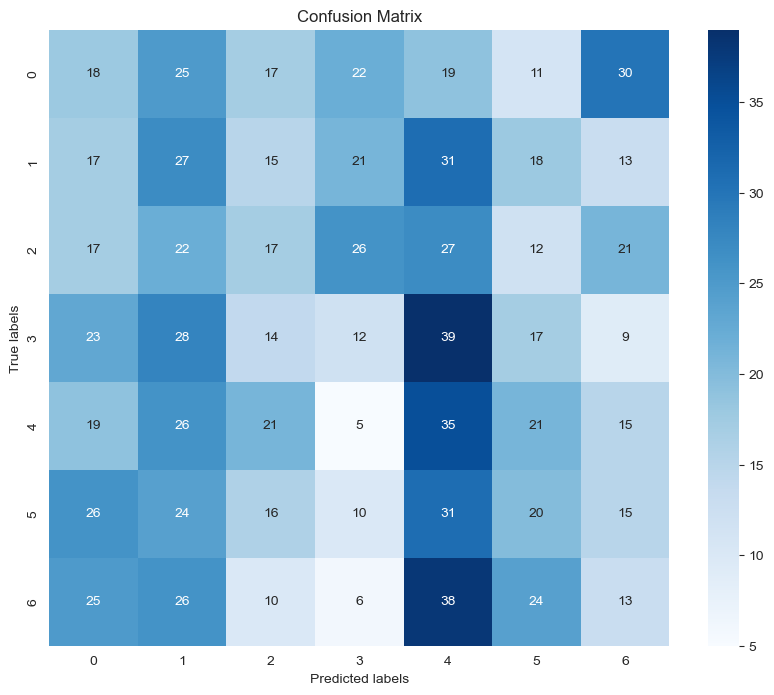

In [26]:
show_confusion_matrix(label_df['round'], label_df['label'])

# Random Forest Classification

For this data it makes sense to use a Random Forest classifier. This is not a binary classifier and this will likely have much more complex relationships than linear ones that need to be sorted. 

The goal here is to try and predict which ROUND the player is drafted in based on their combine performance. There is 7 possible outcomes. Rounds 1 - 7, where 1 is the highest round. 

Tha target variable in this dataset is of course the round variable. So let's isolate that and split the data into testing and training sets. 

In [27]:
features = final_combine_data.drop('round', axis=1)
target = final_combine_data['round']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)

Now let's create an instance of a Random Forest model with the default model parameters, we can adjust these later once we get the results. 

In [28]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Now predicting with the testing set...

In [29]:
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.19597989949748743


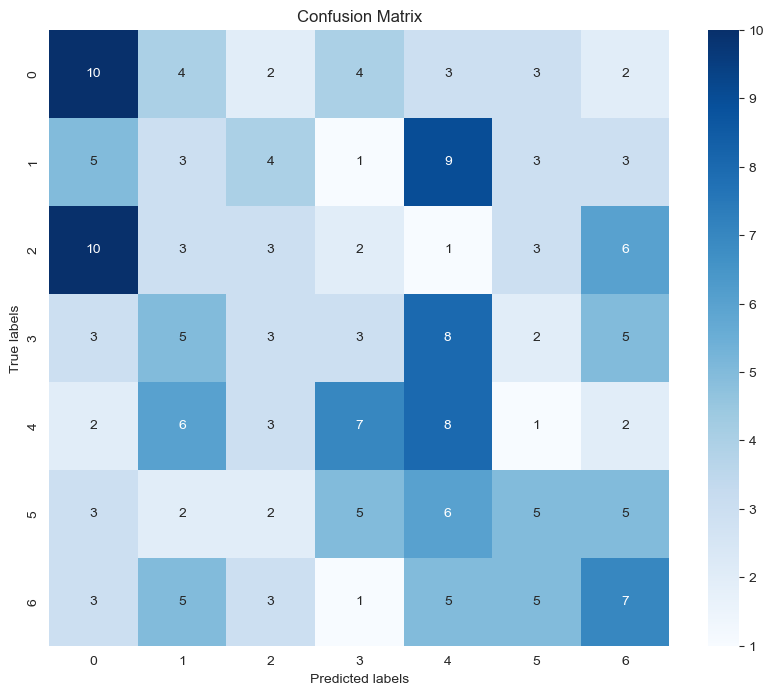

In [30]:
show_confusion_matrix(y_test, y_pred)

In [31]:
pears_list = []
for pos in filtered_positions:
    pos_df = merged_df[merged_df["Pos"] == pos]
    for drill in drills:
        pears, p = pearsonr(x=pos_df[drill], y=pos_df['overall'])
        pears_list.append([str(pos), drill, pears, p])
      
pears_header = ["Position", "Drill", "Pearson Coefficient", "P value"]
# print(tabulate(pears_list, headers=pears_header, tablefmt="grid"))
pears_df = pd.DataFrame(pears_list)
pears_df.head(108)

,0,1,2,3
0,CB,40yd,0.321129,0.000001
1,CB,Vertical,-0.148725,0.027408
2,CB,Bench,-0.100245,0.138302
3,CB,Broad Jump,-0.233329,0.000484
4,CB,3Cone,0.239351,0.000341
...,...,...,...,...
103,DB,Vertical,0.030043,0.912055
104,DB,Bench,0.101532,0.708291
105,DB,Broad Jump,0.002045,0.994002
106,DB,3Cone,0.266228,0.318925


### Results

The accuracy was around 18%, which of course is not the best accuracy for what we are trying to accomplish. However, the confusion matrix above provides a lot more information on the results. 

From the matrix above we can see that the model was overall close in a lot of its guesses, the farther away the true round was the less amount of guesses. This is what we expect. 

But we can hopefully get the accuracy of this up some more with some model tuning.

## Scaling Features 

A way we can possibly improve performance is by scaling the features before using it in the model. This would prevent features from overpowering one another.

In [32]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred = rf.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.18090452261306533


## Selecting Different Features

Now that we have a baseline model we can try altering some of the features being used in the random forest, some of them may be redundant and not needed. 

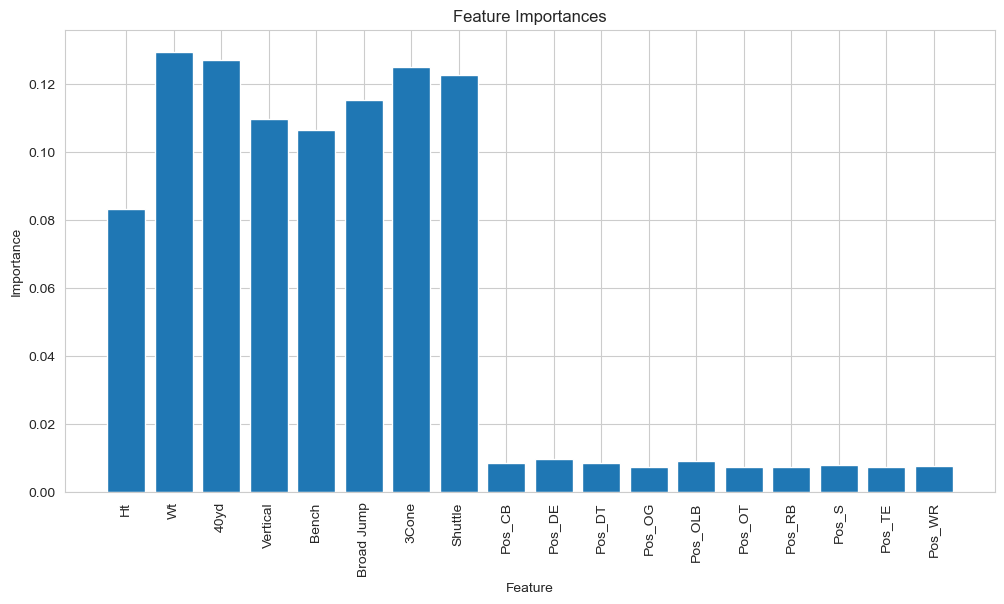

In [33]:
feature_importances = rf.feature_importances_
feature_names = features.columns

plt.figure(figsize=(12, 6))
plt.bar(range(len(feature_importances)), feature_importances, align='center')
plt.xticks(range(len(feature_importances)), feature_names, rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()

Surprisingly enough the positions do not seem to be making much of an impact in the data compared to other features. Which is not expected because the position a player is should impact their scores on the combine drills. Nonetheless, let's try seeing how the model behaves without the positions being accounted for. 

In [34]:
relevant_features = ['Ht', 'Wt', '40yd', 'Vertical', 'Bench', 'Broad Jump', '3Cone', 'Shuttle']

filtered_features = final_combine_data[relevant_features]
X_train, X_test, y_train, y_test = train_test_split(filtered_features, target, test_size=0.2, random_state=42, stratify=target)

In [35]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred = rf.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.19597989949748743


As expected, removing the positions really hurt the model. This is not a good route to go, instead lets try selecting features using a greedy approach.

## Choosing Features via a Greedy Approach

In [36]:
def generate_greedy_model(features, target, rf):

    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)

    best_selected_features = set()

    feature_importances = []

    best_accuracy = 0.0

    while len(best_selected_features) < len(X_train.columns):
        best_feature = None
        best_accuracy_iter = best_accuracy

        # Iterate over all features
        for feature in X_train.columns:
            # Skip if feature is already selected
            if feature in best_selected_features:
                continue

            # Add feature to selected features
            candidate_features = list(best_selected_features) + [feature]

            # Train the model with the candidate features
            rf.fit(X_train[candidate_features], y_train)
            y_pred = rf.predict(X_test[candidate_features])

            # Calculate accuracy
            accuracy = accuracy_score(y_test, y_pred)

            # Update best feature if accuracy improves
            if accuracy > best_accuracy_iter:
                best_accuracy_iter = accuracy
                best_feature = feature

        # If no feature improves accuracy, stop doing this method
        if best_feature is None:
            break

        # Add best feature to selected features
        best_selected_features.add(best_feature)
        feature_importances.append((best_feature, best_accuracy_iter))
        best_accuracy = best_accuracy_iter

        # Save the best model
        best_model = copy.deepcopy(rf)

    # Print selected features and their importance
    print("Selected Features:")
    for feature, importance in feature_importances:
        print(f"{feature}: {importance}")

    print(f'Best Accuracy: {best_accuracy}')
    rf.fit(X_train[list(best_selected_features)], y_train)
    y_pred = rf.predict(X_test[list(best_selected_features)])
    show_confusion_matrix(y_test, y_pred)

Selected Features:
Ht: 0.17587939698492464
Pos_RB: 0.18090452261306533
Pos_S: 0.18592964824120603
Best Accuracy: 0.18592964824120603


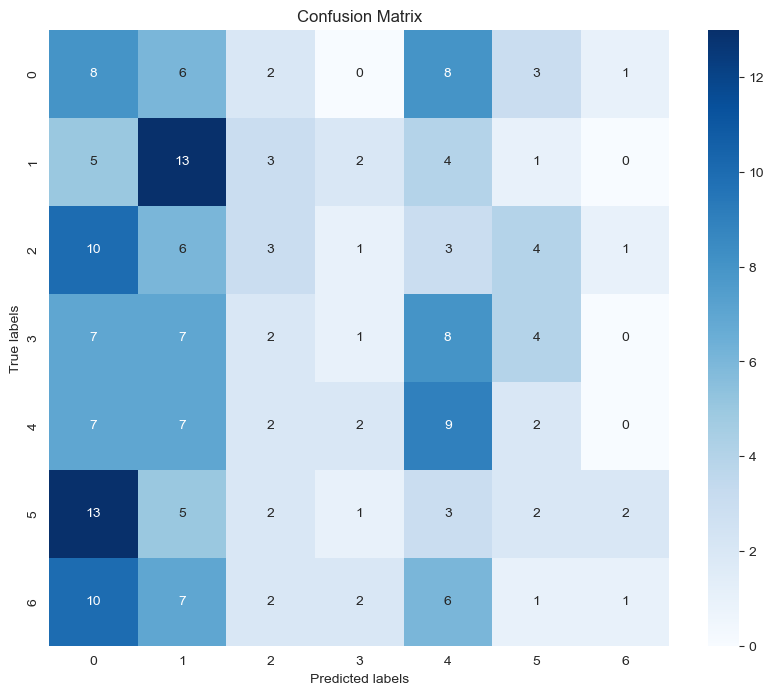

In [37]:
generate_greedy_model(features, target, RandomForestClassifier(random_state=42))

### Results of Greedy Approach

Improvement! This is a decent improvement from the previous best accuracy. Although the greedy approach did better, it is still possible that there are better ways to choose features, doing the greedy approach does not guarantee the best set of features. 

## Choosing Features via Forward Selection

Forward Selection is a technique that starts with an empty set of features and adds features one by one, selecting the feature that best imporves the model performance. It will stop when adding more features no longer improves the performance of the model. 

In [38]:
def generate_forward_selection_model(features, target, rf):

    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)

    selected_features = set()

    # Initialize the best accuracy
    best_accuracy = 0.0

    # Perform forward selection
    while len(selected_features) < len(X_train.columns):
        best_feature = None
        best_accuracy_iter = best_accuracy

        # Iterate over all features
        for feature in X_train.columns:
            # Skip if feature is already selected
            if feature in selected_features:
                continue

            # Add feature to selected features
            candidate_features = list(selected_features) + [feature]

            # Train the model with the candidate features
            rf.fit(X_train[candidate_features], y_train)
            y_pred = rf.predict(X_test[candidate_features])

            # Calculate accuracy
            accuracy = accuracy_score(y_test, y_pred)

            # Update best feature if accuracy improves
            if accuracy > best_accuracy_iter:
                best_accuracy_iter = accuracy
                best_feature = feature

        # If no feature improves accuracy, stop
        if best_feature is None:
            break

        # Add best feature to selected features
        selected_features.add(best_feature)
        best_accuracy = best_accuracy_iter

    # Print selected features
    print("Selected Features:")
    print(selected_features)

    # Train the final model with the selected features
    final_feature_names = list(selected_features)
    rf.fit(X_train[final_feature_names], y_train)

    # Make predictions on the test set
    y_pred = rf.predict(X_test[final_feature_names])

    # Calculate the final accuracy
    final_accuracy = accuracy_score(y_test, y_pred)
    print("Final Accuracy:", final_accuracy)
    show_confusion_matrix(y_test, y_pred)
    return y_test, y_pred

In [ ]:
generate_forward_selection_model(features, target, RandomForestClassifier(random_state=42))

## Hyperparameter Tuning

Now that we have used two different methods to select the best features for the classifier, we can try to tune the hyperparameter of the model to get a better result. To do this we are going to use GridSearch to find the best possible hyperparameter out of a set of predetermined options.

In [ ]:
rf = RandomForestClassifier(random_state=42)

param_grid = {
  'n_estimators': [100, 200, 300],  # Number of trees in the forest
  'max_depth': [4, 6, 8],  # Maximum depth of individual trees
  'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
  'min_samples_leaf': [1, 2, 4],  # Minimum samples required at each leaf node
  'max_features': ['auto', 'sqrt', 'log2'],  # Number of features considered for splitting
  'criterion': ['gini', 'entropy']  # Function to measure the quality of a split
}

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)

In [ ]:
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
show_confusion_matrix(y_test, y_pred)

In [ ]:
generate_greedy_model(features, target, best_model)

In [ ]:
y_test, y_pred = generate_forward_selection_model(features, target, best_model)

# Results Analysis

The best model was able to get around 23% accuracy. This is not a high score, but it is not that simple. In NFL drafts the players drafted at round 1 are very similar in performance to those drafted in round 2. And we can see that the model often confuses that as such. Same goes for round 6 and around 7. And any other rounds that are close together. 

Based on our overall accuracy it is easy to say that there is really no correlation between combine performance and draft position. But to further analyze this let's generalize the rounds of the draft a little more, instead of there being seven possible outcomes lets see how well the model did with only two possible outcomes, the front half and the back half of the draft. 

Maybe then we can draw some conclusions on how combine performance affects draft position on a more general scale. 

Let's split up the data so that the front half of the draft corresponds to rounds 1-4 and the back half corresponds to 5-7



In [ ]:
results = []
for test_val, pred_val in zip(y_test, y_pred):
    if test_val <= 4 and pred_val <=4:
        results.append(1)
    elif test_val > 4 and pred_val > 4:
        results.append(1)
    else:
        results.append(0)

In [ ]:
print(f'Accuracy: {np.sum(results) / len(results)}')

According to the above results we get around a 60% accuracy, just a little bit over what you would get if you guess every time. This is enough evidence to say that there is no significant correlation between the draft position of an NFL player and their combine performance. 

There is some significance, and that is expected, but just not enough to accurately predict where a player is going to be drafted. 



### Possible Improvements

If we wanted to improve these results, it might be worthwhile to focus more on present day drafts than drafts from the early 2000s as well. The way football is played today is much different than it was even just 20 years ago, and our data might not represent that as well as it could. Today more than ever the most emphasis is placed on the speed of a player. So combine metrics might hold more weight in the present compared to drafts ranging back all the way to the 2000s. 

### Lessons Learned

We learned that the NFL combine does not matter as much as we initially thought. We always saw the NFL combine as a way for players to really show their skills, but in fact that is not necessarily the case. Their college performance is and most likely always will be the biggest predictor of when players will get drafted. 